## QTL Ensembl VEP

**Created**: 10 June 2022

## Environment

In [1]:
library(tidyverse)
library(data.table)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load VEP Data

In [2]:
vep <- fread("~/gains_team282/epigenetics/vep/ensembl_vep/qtl_vep_output.tsv", sep="\t", na.strings="") %>%
    as.data.frame()

VEP results are uniquely indexed by SNP (`ID`), allele (`Allele`), and affected feature (`Feature`). There can be multiple consequences per feature, that are all combined together. I will split these based on the consequence so that the new data frame is uniquely indexed by `ID`, `Allele`, `Feature`, and `Consequence`.

In [3]:
vep <- vep %>%
    separate_rows(Consequence, sep="&")

For input into VEP, I had included both versions of the SNP (with both alleles as effect alleles) to get all possible annoations.

In [4]:
ref.map <- read.table("~/gains_team282/epigenetics/vep/ensembl_vep/qtl_ref_alleles.tsv") %>%
    dplyr::select(ID=3, dbSNP_Ref=4)

## Load QTL Data

In [5]:
gene.info <- read.table("/nfs/team282/data/gains_team282/gene_info_864_20412_hla.txt") %>%
    dplyr::select(gene_id, gene_name)

In [6]:
c.cis.eqtl <- readRDS("~/gains_team282/eqtl/cisresults/conditionalanalysis/conditional_eQTL_results_final.rds") %>%
    merge(gene.info, ., by.x="gene_id", by.y="Gene")

In [7]:
head(c.cis.eqtl)

,gene_id,gene_name,SNP,eQTL_beta,eQTL_SE,pvalue,Number
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,ENSG00000000457,SCYL3,rs10753794,0.0498587312408011,0.00708515851579373,5.19259471106013e-12,1
2,ENSG00000000460,C1orf112,rs10919255,-0.0726264894633498,0.0136853304567293,1.72815915933528e-07,1
3,ENSG00000000460,C1orf112,rs77006036,0.166236949102582,0.0334472538699365,8.47290238610159e-07,2
4,ENSG00000000971,CFH,rs12406047,0.17135374034767,0.0379807691167313,7.51523462853891e-06,1
5,ENSG00000001036,FUCA2,rs2496591,0.055563884637757,0.00962802684955264,1.2720712155449e-08,1
6,ENSG00000001167,NFYA,rs72856259,0.119809332267369,0.0158643249832696,1.97855077155375e-13,1


In [8]:
dim(c.cis.eqtl)

[1] 16054     7

In [9]:
mqtl <- readRDS("~/gains_team282/nikhil/expression/eigengene_sva/mqtl.RDS") %>%
    dplyr::group_by(module, qtl.locus) %>%
    dplyr::slice_min(p, n=1, with_ties=F)

In [10]:
head(mqtl)

snp,beta,se,t,p,module.qtl,module,pc,qtl.locus,qtl.locus.chr,qtl.locus.start,qtl.locus.end
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
rs16866400,-0.01081391,0.0016948840,-6.380325,3.197894e-10,ME_100_4-2:177556567-179584183,ME_100,4,2:177556567-179584183,2,177556567,179584183
rs582717,-0.02334898,0.0014724757,-15.856953,7.745374e-48,ME_101_2-1:24243590-26454176,ME_101,2,1:24243590-26454176,1,24243590,26454176
rs1131017,0.02409859,0.0008054830,29.918193,7.188768e-121,ME_101_3-12:54985643-57100037,ME_101,3,12:54985643-57100037,12,54985643,57100037
rs12442141,0.04014834,0.0033260563,12.070853,1.789047e-30,ME_101_5-15:30215896-32681425,ME_101,5,15:30215896-32681425,15,30215896,32681425
rs629329,0.02986714,0.0014708263,20.306367,5.848637e-71,ME_102_1-17:17145294-19676395,ME_102,1,17:17145294-19676395,17,17145294,19676395
rs4761234,0.01989013,0.0005288609,37.609373,8.488460e-164,ME_103_3-12:68275923-70376531,ME_103,3,12:68275923-70376531,12,68275923,70376531


In [11]:
cis.pqtl <- readRDS("/nfs/users/nfs_n/nm18/gains_team282/proteomics/pqtl/pqtl_ms2019/cis_pqtl_all.RDS") %>%
    dplyr::filter(pQTL_pval < (5e-8) / 269) %>%
    dplyr::group_by(Gene) %>%
    dplyr::slice_min(pQTL_pval, n=1, with_ties=F)

In [12]:
trans.pqtl <- readRDS("/nfs/users/nfs_n/nm18/gains_team282/proteomics/pqtl/pqtl_ms2019/trans_pqtl_all.RDS") %>%
    dplyr::filter(pQTL_pval < (5e-8) / 269) %>%
    dplyr::group_by(pQTL_Protein, pQTL_Locus) %>%
    dplyr::slice_min(pQTL_pval, n=1, with_ties=F)

In [13]:
head(cis.pqtl)

SNP,Chr,Position,pQTL_beta,pQTL_SE,pQTL_t,pQTL_pval,pQTL_Protein,Gene
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
rs529541,1,196750586,-0.24905935,0.01325800,-18.785585,1.642588e-67,P08603,ENSG00000000971
rs854572,7,95325384,0.18402863,0.01585951,11.603674,3.259335e-29,P27169,ENSG00000005421
rs6073958,20,45923216,-0.14494261,0.01847291,-7.846223,8.488455e-15,P55058,ENSG00000100979
rs7815785,8,17872829,-0.22225713,0.02073768,-10.717549,2.077001e-25,Q08830,ENSG00000104760
rs1648722,3,186731200,-0.06974747,0.01034678,-6.740986,2.709794e-11,P01042,ENSG00000113889
rs9898,3,186672838,0.13927636,0.01226248,11.357931,2.911146e-28,P04196,ENSG00000113905


In [14]:
head(trans.pqtl)

SNP,Chr,Position,pQTL_beta,pQTL_SE,pQTL_t,pQTL_pval,pQTL_Protein,pQTL_Locus
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
rs11846959,14,94379979,-0.3065649,0.01614662,-18.986322,3.309735e-69,P00751,pQTL_1
rs11846959,14,94379979,-0.2137874,0.01793464,-11.920362,6.923034e-31,P02787,pQTL_1
rs9302635,16,72110275,0.1145890,0.01466176,7.815500,1.200982e-14,P10909,pQTL_1
rs9302635,16,72110275,0.1319606,0.01429908,9.228609,1.454631e-19,P19827,pQTL_1
rs16917722,8,95461382,-0.4991650,0.06949047,-7.183215,1.673847e-12,P35858,pQTL_1
rs28929474,14,94378610,0.5651334,0.07657069,7.380545,3.282674e-13,Q92954,pQTL_1


## Cis-eQTL

Tables on these features are provided by [McLaren *et al.*](https://doi.org/10.1186/s13059-016-0974-4).

In [15]:
c.cis.eqtl.vep <- merge(vep, c.cis.eqtl, by.x="ID", by.y="SNP") %>%
    dplyr::select(
        ID, Allele, Feature, Consequence,                                    # Index variables
        CHROM, POS, REF, ALT,                                                # Variant information
        eGene=gene_id,                                                       # Cis-eQTL information
        Gene, Feature_type, BIOTYPE,                                         # Gene and transcript information
        ENSP, UNIPARC, SIFT, PolyPhen,                                       # Protein information
        MOTIF_NAME, TRANSCRIPTION_FACTORS, HIGH_INF_POS, MOTIF_SCORE_CHANGE, # Transcription factor information
        CLIN_SIG                                                             # Literature annotations
    )

All 14,938 unique lead conditional cis-eQTL have at least one VEP annotation.

In [16]:
c.cis.eqtl.vep %>%
    dplyr::count(ID) %>%
    nrow()

c.cis.eqtl %>%
    dplyr::count(SNP) %>%
    nrow()

[1] 14938

[1] 14938

Most variants had a predicted consequence on one gene. Surprisingly, many of the predicted consequences were not for the actual eGene. Only 6351 (44.4%) of variants had a predicted consequence on the eGene.

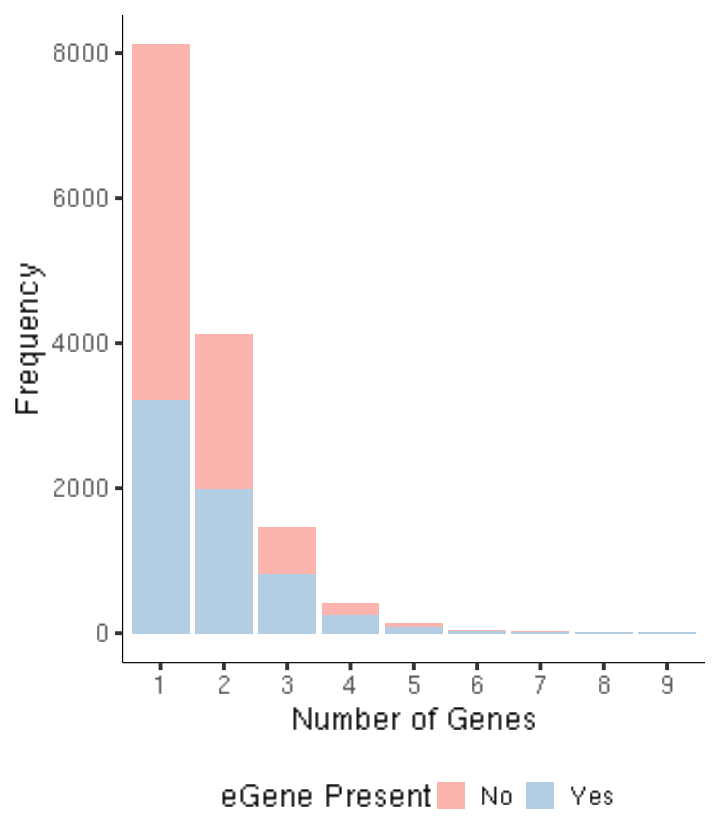

In [17]:
options(repr.plot.width=6, repr.plot.height=7)

c.cis.eqtl.vep %>%
    dplyr::filter(Feature_type == "Transcript") %>%
    dplyr::select(ID, Gene, eGene) %>%
    unique() %>%
    dplyr::group_by(ID, eGene) %>%
    dplyr::summarize(Matches = c("No", "Yes")[as.numeric(any(eGene == Gene)) + 1], n=n(), .groups="drop") %>%
    dplyr::mutate(n=factor(n, levels=1:max(n))) %>%
    dplyr::count(n, Matches, name="Frequency") %>%
    ggplot() +
    geom_bar(aes(x=n, y=Frequency, fill=Matches), stat="identity") +
    scale_fill_brewer("eGene Present", palette="Pastel1") +
    xlab("Number of Genes") + ylab("Frequency") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/ensembl_vep_n_genes.pdf", width=8, height=9)

In [18]:
c.cis.eqtl.vep %>%
    dplyr::filter(Feature_type == "Transcript") %>%
    dplyr::select(ID, Gene, eGene) %>%
    unique() %>%
    dplyr::count(ID, eGene) %>%
    dplyr::count(n) %>%
    dplyr::mutate(total = sum(nn)) %>%
    dplyr::mutate(prop = nn / total)

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.


n,nn,total,prop
<int>,<int>,<int>,<dbl>
1,8121,14319,0.5671485439
2,4122,14319,0.2878692646
3,1462,14319,0.1021021021
4,411,14319,0.0287031217
5,138,14319,0.0096375445
6,36,14319,0.0025141420
7,18,14319,0.0012570710
8,7,14319,0.0004888610
9,4,14319,0.0002793491


In [19]:
c.cis.eqtl.vep %>%
    dplyr::filter(Feature_type == "Transcript") %>%
    dplyr::select(ID, eGene, Gene) %>%
    dplyr::group_by(ID, eGene) %>%
    dplyr::summarize(Matches = any(eGene == Gene), .groups="drop") %>%
    dplyr::count(Matches) %>%
    dplyr::mutate(Prop=n / sum(n))

Matches,n,Prop
<lgl>,<int>,<dbl>
FALSE,7968,0.5564634
TRUE,6351,0.4435366


Why? Maybe those variants are falling in regulatory regions that are not annotated with a gene?

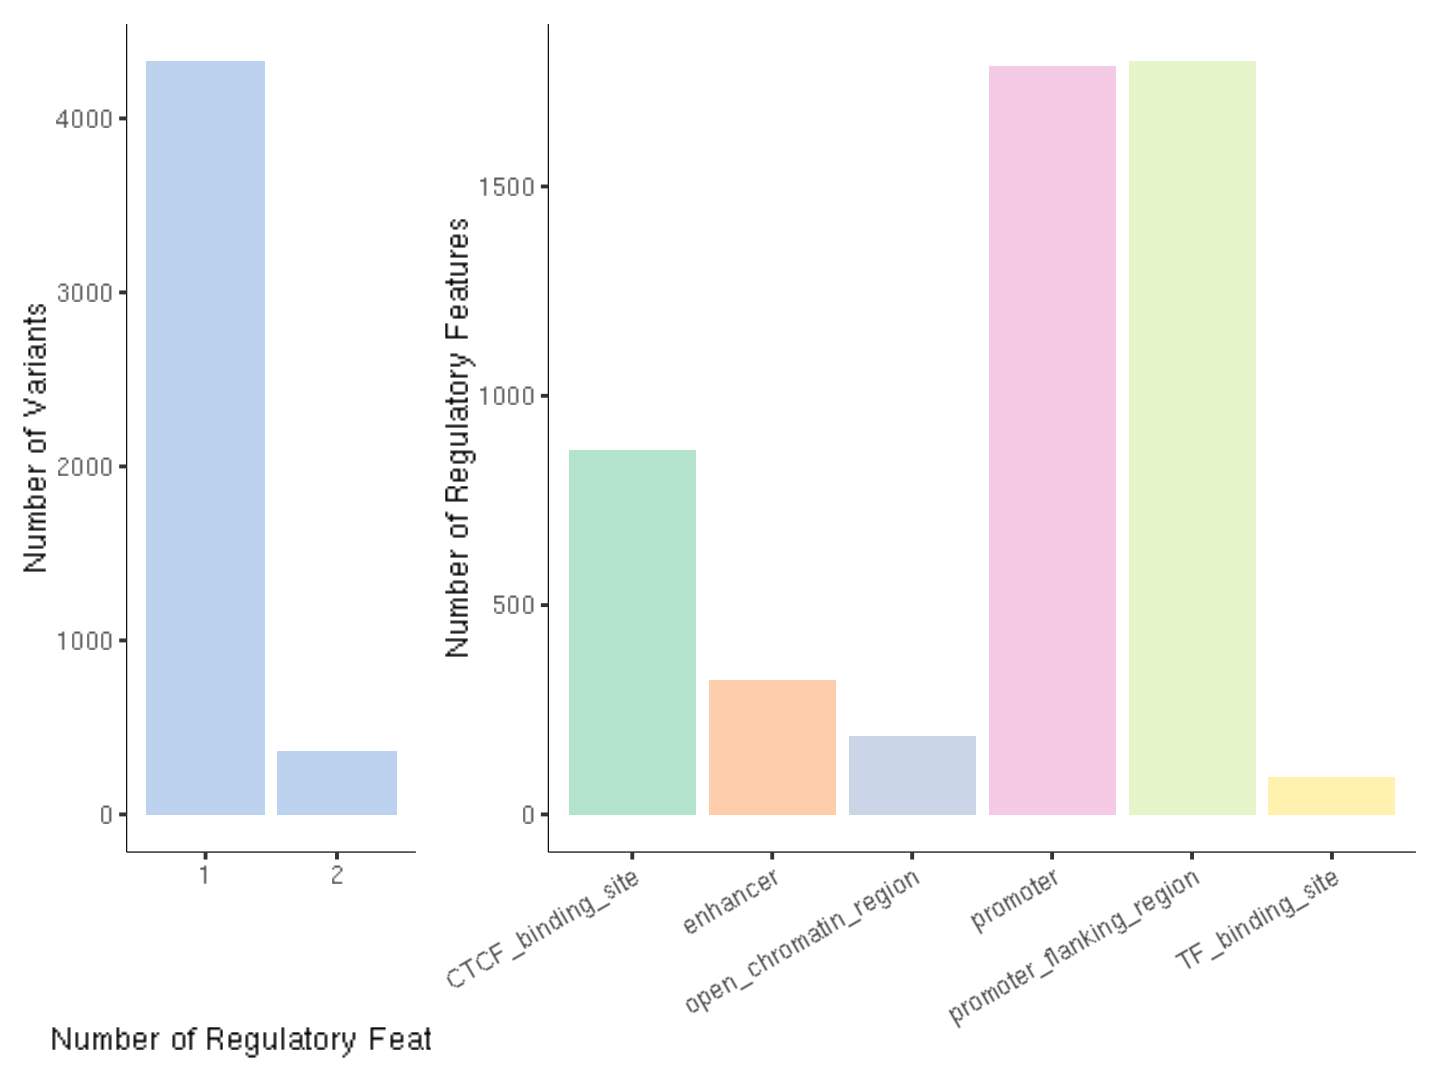

In [20]:
options(repr.plot.width=12, repr.plot.height=9)

p1 <- c.cis.eqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature) %>%
    unique() %>%
    dplyr::count(ID) %>%
    dplyr::mutate(n=factor(n, levels=1:max(n))) %>%
    ggplot() +
    geom_bar(aes(x=n), fill="lightsteelblue2") +
    xlab("Number of Regulatory Features") + ylab("Number of Variants") +
    ggplot_theme

p2 <- c.cis.eqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature, BIOTYPE) %>%
    unique() %>%
    ggplot() +
    geom_bar(aes(x=BIOTYPE, fill=BIOTYPE)) +
    guides(fill="none") + ylab("Number of Regulatory Features") +
    scale_fill_brewer(palette="Pastel2") +
    ggplot_theme +
    theme(axis.text.x=element_text(angle=30, hjust=1), axis.title.x=element_blank())

p1 + p2 + patchwork::plot_layout(widths=c(1, 3))

ggsave("03_Functional_Interpretation/results/ensembl_vep_n_regulatory_features.pdf", width=12, height=9)

In [21]:
c.cis.eqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature) %>%
    unique() %>%
    dplyr::count(ID) %>%
    dplyr::count(n) %>%
    dplyr::mutate(total=sum(nn)) %>%
    dplyr::mutate(prop=nn / total)

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.


n,nn,total,prop
<int>,<int>,<int>,<dbl>
1,4326,4687,0.92297845
2,361,4687,0.07702155


In [22]:
c.cis.eqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature, BIOTYPE) %>%
    unique() %>%
    dplyr::count(BIOTYPE) %>%
    dplyr::mutate(total=sum(n)) %>%
    dplyr::mutate(prop=n / total)

BIOTYPE,n,total,prop
<chr>,<int>,<int>,<dbl>
CTCF_binding_site,869,5048,0.17214739
enhancer,321,5048,0.06358954
open_chromatin_region,185,5048,0.03664818
promoter,1787,5048,0.35400158
promoter_flanking_region,1798,5048,0.35618067
TF_binding_site,88,5048,0.01743265


Some variants are also in motifs. There are 639 motif-modifying variants. These affect 259 motifs, spread across 1716 unique genomic features across the genome.

In [23]:
c.cis.eqtl.vep %>%
    dplyr::filter(Feature_type == "MotifFeature") %>%
    merge(., ref.map, by="ID") %>%
    dplyr::filter(REF == dbSNP_Ref) %>%
    dplyr::count(ID) %>%
    nrow()

[1] 639

In [24]:
c.cis.eqtl.vep %>%
    dplyr::filter(Feature_type == "MotifFeature") %>%
    merge(., ref.map, by="ID") %>%
    dplyr::filter(REF == dbSNP_Ref) %>%
    dplyr::count(MOTIF_NAME) %>%
    nrow()

[1] 259

In [25]:
c.cis.eqtl.vep %>%
    dplyr::filter(Feature_type == "MotifFeature") %>%
    merge(., ref.map, by="ID") %>%
    dplyr::filter(REF == dbSNP_Ref) %>%
    dplyr::count(Feature) %>%
    nrow()

[1] 1716

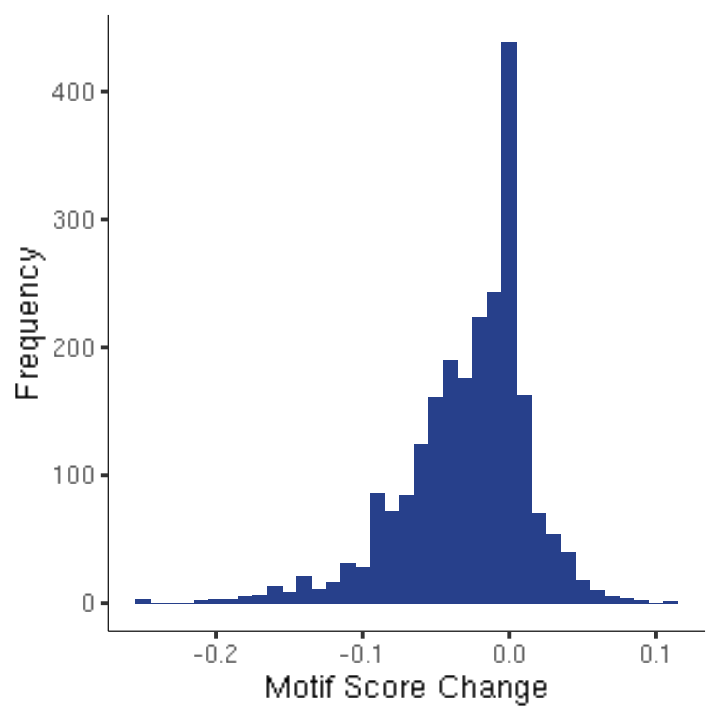

In [28]:
options(repr.plot.width=6, repr.plot.height=6)

c.cis.eqtl.vep %>%
    dplyr::filter(Feature_type == "MotifFeature") %>%
    merge(., ref.map, by="ID") %>%
    dplyr::filter(REF == dbSNP_Ref) %>%
    ggplot() +
    geom_histogram(aes(x=MOTIF_SCORE_CHANGE), binwidth=0.01, fill="royalblue4") +
    xlab("Motif Score Change") + ylab("Frequency") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/ensembl_vep_motif_score_change.pdf", width=6, height=6)

## Module QTL

Tables on these features are provided by [McLaren *et al.*](https://doi.org/10.1186/s13059-016-0974-4).

In [29]:
mqtl.vep <- merge(vep, mqtl, by.x="ID", by.y="snp") %>%
    dplyr::select(
        ID, Allele, Feature, Consequence,                                    # Index variables
        CHROM, POS, REF, ALT,                                                # Variant information
        module.qtl, module, pc, qtl.locus,                                   # Module QTL information
        Gene, Feature_type, BIOTYPE,                                         # Gene and transcript information
        ENSP, UNIPARC, SIFT, PolyPhen,                                       # Protein information
        MOTIF_NAME, TRANSCRIPTION_FACTORS, HIGH_INF_POS, MOTIF_SCORE_CHANGE, # Transcription factor information
        CLIN_SIG                                                             # Literature annotations
    )

Of the 76 unique lead module QTL variants, one variant does not have a predicted consequence.

In [30]:
mqtl.vep %>%
    dplyr::count(ID) %>%
    nrow()

mqtl %>%
    dplyr::count(snp) %>%
    nrow()

[1] 75

[1] 76

Variants were predicted to affect between 1 and 4 genes.

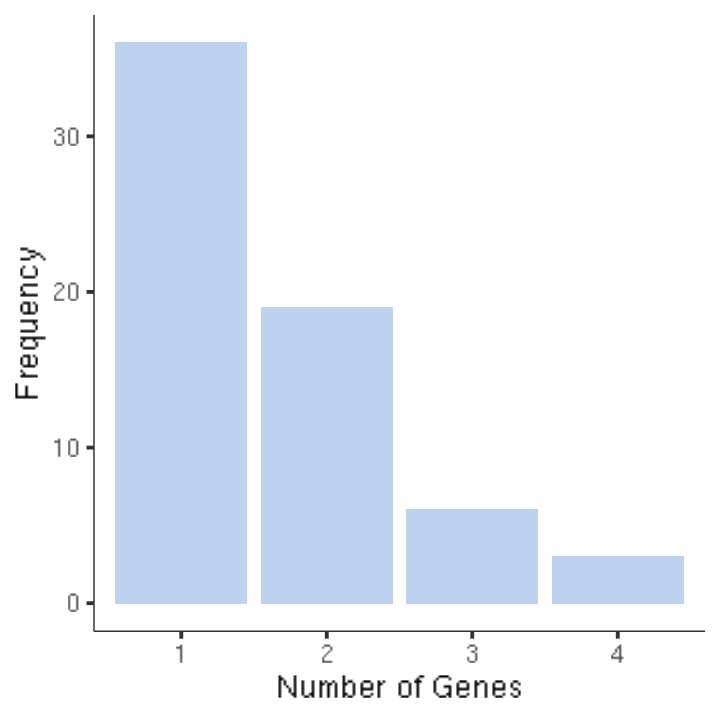

In [32]:
options(repr.plot.width=6, repr.plot.height=6)

mqtl.vep %>%
    dplyr::filter(Feature_type == "Transcript") %>%
    dplyr::select(ID, Gene) %>%
    unique() %>%
    dplyr::count(ID) %>%
    dplyr::mutate(n=factor(n, levels=1:max(n))) %>%
    dplyr::count(n, name="Frequency") %>%
    ggplot() +
    geom_bar(aes(x=n, y=Frequency), stat="identity", fill="lightsteelblue2") +
    xlab("Number of Genes") + ylab("Frequency") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/ensembl_vep_mqtl_n_genes.pdf", width=6, height=6)

In [33]:
mqtl.vep %>%
    dplyr::filter(Feature_type == "Transcript") %>%
    dplyr::select(ID, Gene) %>%
    unique() %>%
    dplyr::count(ID) %>%
    dplyr::count(n) %>%
    dplyr::mutate(total = sum(nn)) %>%
    dplyr::mutate(prop = nn / total)

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.


n,nn,total,prop
<int>,<int>,<int>,<dbl>
1,36,64,0.562500
2,19,64,0.296875
3,6,64,0.093750
4,3,64,0.046875


Why? Maybe those variants are falling in regulatory regions that are not annotated with a gene?

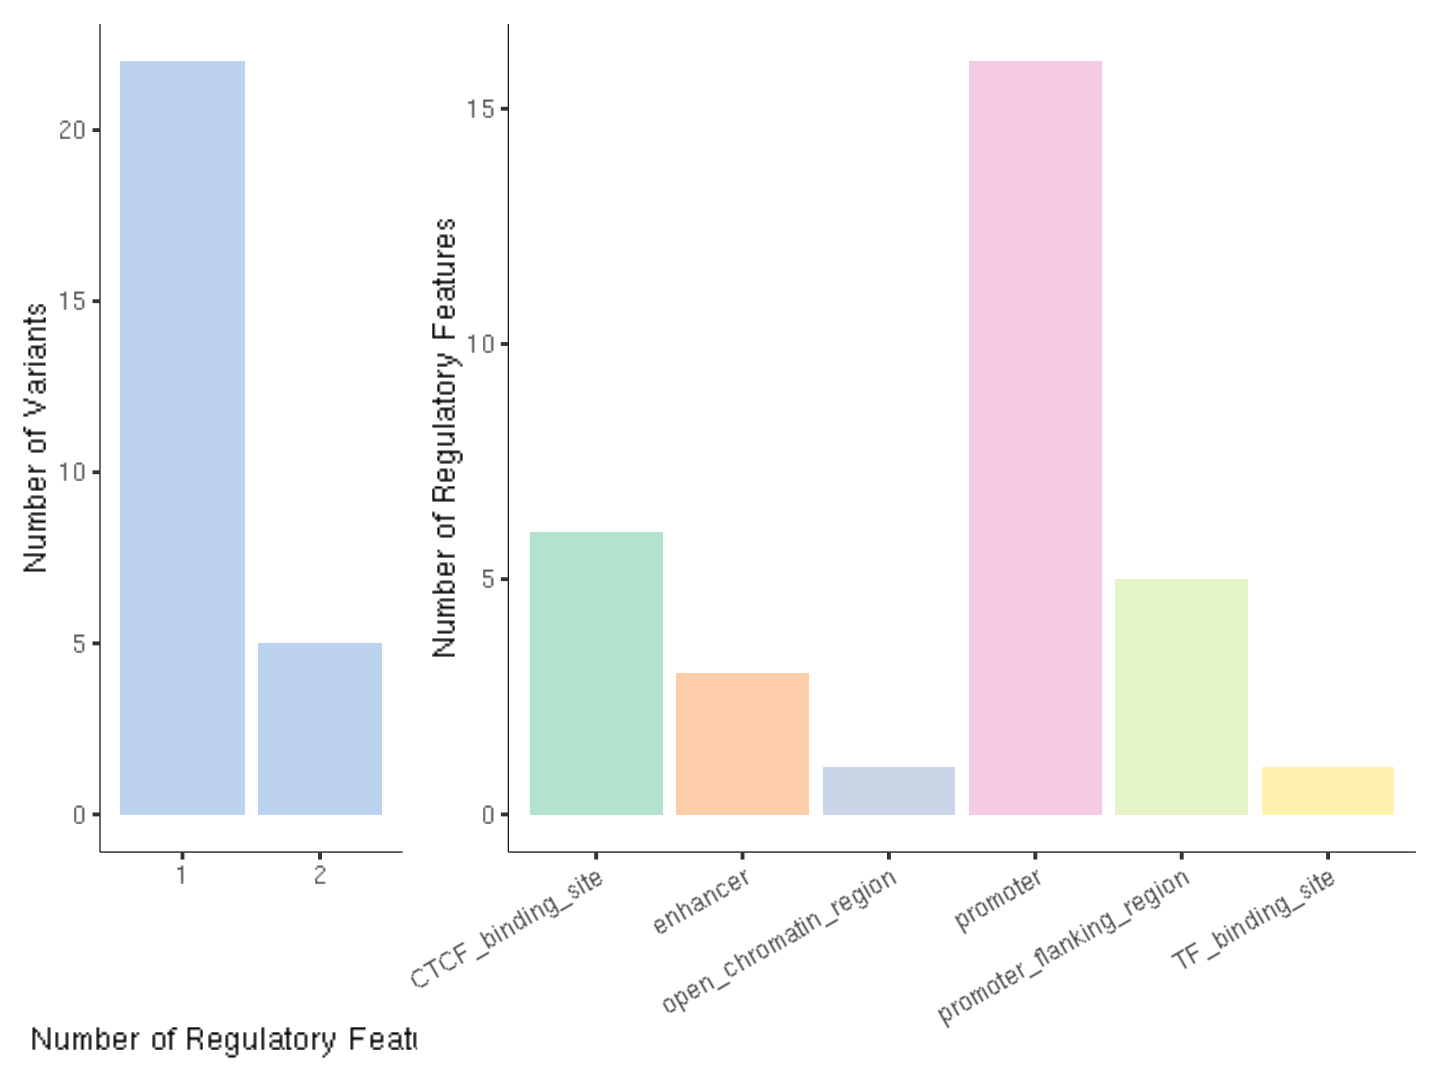

In [35]:
options(repr.plot.width=12, repr.plot.height=9)

p1 <- mqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature) %>%
    unique() %>%
    dplyr::count(ID) %>%
    dplyr::mutate(n=factor(n, levels=1:max(n))) %>%
    ggplot() +
    geom_bar(aes(x=n), fill="lightsteelblue2") +
    xlab("Number of Regulatory Features") + ylab("Number of Variants") +
    ggplot_theme

p2 <- mqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature, BIOTYPE) %>%
    unique() %>%
    ggplot() +
    geom_bar(aes(x=BIOTYPE, fill=BIOTYPE)) +
    guides(fill="none") + ylab("Number of Regulatory Features") +
    scale_fill_brewer(palette="Pastel2") +
    ggplot_theme +
    theme(axis.text.x=element_text(angle=30, hjust=1), axis.title.x=element_blank())

p1 + p2 + patchwork::plot_layout(widths=c(1, 3))

ggsave("03_Functional_Interpretation/results/ensembl_vep_mqtl_n_regulatory_features.pdf", width=12, height=9)

In [32]:
mqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature) %>%
    unique() %>%
    dplyr::count(ID) %>%
    dplyr::count(n) %>%
    dplyr::mutate(total=sum(nn)) %>%
    dplyr::mutate(prop=nn / total)

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.


n,nn,total,prop
<int>,<int>,<int>,<dbl>
1,22,27,0.8148148
2,5,27,0.1851852


In [33]:
mqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature, BIOTYPE) %>%
    unique() %>%
    dplyr::count(BIOTYPE) %>%
    dplyr::mutate(total=sum(n)) %>%
    dplyr::mutate(prop=n / total)

BIOTYPE,n,total,prop
<chr>,<int>,<int>,<dbl>
CTCF_binding_site,6,32,0.18750
enhancer,3,32,0.09375
open_chromatin_region,1,32,0.03125
promoter,16,32,0.50000
promoter_flanking_region,5,32,0.15625
TF_binding_site,1,32,0.03125


Some variants are also in motifs. There are 8 motif-modifying variants. These affect 12 motifs for 12 different features.

In [34]:
mqtl.vep %>%
    dplyr::filter(Feature_type == "MotifFeature") %>%
    merge(., ref.map, by="ID") %>%
    dplyr::filter(REF == dbSNP_Ref) %>%
    dplyr::count(ID) %>%
    nrow()

[1] 8

In [35]:
mqtl.vep %>%
    dplyr::filter(Feature_type == "MotifFeature") %>%
    merge(., ref.map, by="ID") %>%
    dplyr::filter(REF == dbSNP_Ref) %>%
    dplyr::count(MOTIF_NAME) %>%
    nrow()

[1] 12

In [36]:
mqtl.vep %>%
    dplyr::filter(Feature_type == "MotifFeature") %>%
    merge(., ref.map, by="ID") %>%
    dplyr::filter(REF == dbSNP_Ref) %>%
    dplyr::count(Feature) %>%
    nrow()

[1] 12

In [64]:
mqtl.vep %>%
    dplyr::filter(Feature_type == "MotifFeature") %>%
    merge(., ref.map, by="ID") %>%
    dplyr::filter(REF == dbSNP_Ref) %>%
    dplyr::select(ID, module.qtl, Feature, MOTIF_NAME, TRANSCRIPTION_FACTORS, HIGH_INF_POS, MOTIF_SCORE_CHANGE) %>%
    dplyr::arrange(module.qtl)

ID,module.qtl,Feature,MOTIF_NAME,TRANSCRIPTION_FACTORS,HIGH_INF_POS,MOTIF_SCORE_CHANGE
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
rs1131017,ME_101_3-12:54985643-57100037,ENSM00206477208,ENSPFM0212,GATA3&GATA5&GATA4,Y,-0.169
rs4761234,ME_103_3-12:68275923-70376531,ENSM00522191985,ENSPFM0289,HNF4A,Y,-0.059
rs1132812,ME_61_3-16:29176355-31186829,ENSM00522283907,ENSPFM0139,ETV2::DLX3&HOXB2::ELF1&HOXB2::ELK3,N,-0.015
rs1023252,ME_62_4-1:10790946-12845916,ENSM00523275582,ENSPFM0238,GCM1::MAX,N,-0.028
rs1023252,ME_62_4-1:10790946-12845916,ENSM00200080579,ENSPFM0120,ERF::MAX&FLI1::MAX,N,-0.025
rs1023252,ME_62_4-1:10790946-12845916,ENSM00523627421,ENSPFM0401,MYBL1::MAX,N,-0.018
rs1023252,ME_62_4-1:10790946-12845916,ENSM00200213036,ENSPFM0564,TEAD4::MAX,N,-0.027
rs7191618,ME_91_2-16:27319469-29953394,ENSM00525404278,ENSPFM0150,ETV2::HOXA2&FLI1::DLX2&HOXB2::ELF1&HOXB2::ELK3&ETV2::DRGX&ELK1::HOXA1&FLI1::DRGX&ETV5::DRGX&ETV5::HOXA2&HOXB2::ELK1,N,0.016
rs11130192,ME_94_5-3:47689679-50854451,ENSM00148106969,ENSPFM0451,POU2F1::ELK1,Y,-0.094


## Cis-pQTL

Tables on these features are provided by [McLaren *et al.*](https://doi.org/10.1186/s13059-016-0974-4).

In [38]:
cis.pqtl.vep <- merge(vep, cis.pqtl, by.x="ID", by.y="SNP") %>%
    dplyr::select(
        ID, Allele, Feature, Consequence,                                    # Index variables
        CHROM, POS, REF, ALT,                                                # Variant information
        pGene=Gene.y,                                                        # pQTL information
        Gene=Gene.x, Feature_type, BIOTYPE,                                  # Gene and transcript information
        ENSP, UNIPARC, SIFT, PolyPhen,                                       # Protein information
        MOTIF_NAME, TRANSCRIPTION_FACTORS, HIGH_INF_POS, MOTIF_SCORE_CHANGE, # Transcription factor information
        CLIN_SIG                                                             # Literature annotations
    )

All 23 lead pQTL variants had a predicted consequence.

In [39]:
cis.pqtl.vep %>%
    dplyr::count(ID) %>%
    nrow()

cis.pqtl %>%
    dplyr::count(SNP) %>%
    nrow()

[1] 23

[1] 23

Most variants had a predicted consequence on one gene. Surprisingly, many of the predicted consequences were not for the actual eGene. Only 6351 (44.4%) of variants had a predicted consequence on the eGene.

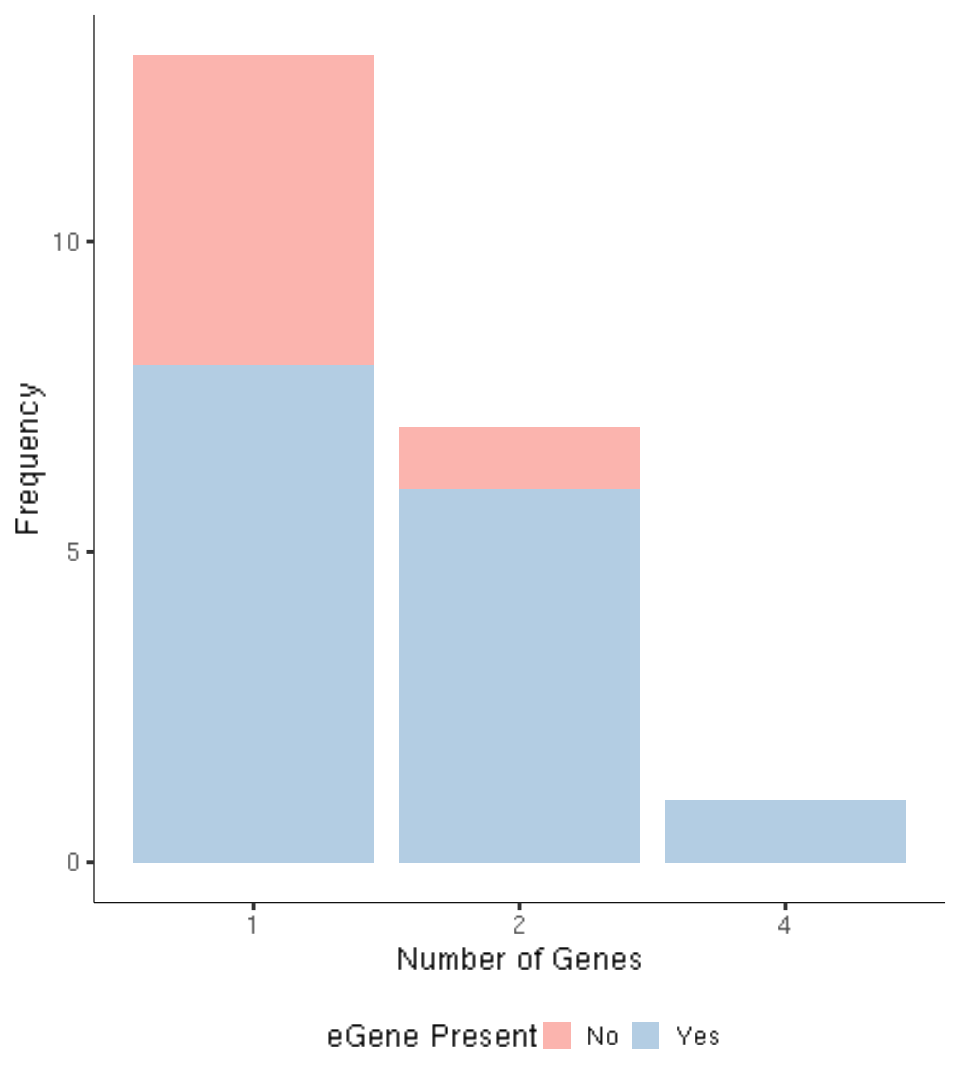

In [40]:
options(repr.plot.width=8, repr.plot.height=9)

cis.pqtl.vep %>%
    dplyr::filter(Feature_type == "Transcript") %>%
    dplyr::select(ID, Gene, pGene) %>%
    unique() %>%
    dplyr::group_by(ID, pGene) %>%
    dplyr::summarize(Matches = c("No", "Yes")[as.numeric(any(pGene == Gene)) + 1], n=n(), .groups="drop") %>%
    dplyr::mutate(n=factor(n, levels=1:max(n))) %>%
    dplyr::count(n, Matches, name="Frequency") %>%
    ggplot() +
    geom_bar(aes(x=n, y=Frequency, fill=Matches), stat="identity") +
    scale_fill_brewer("eGene Present", palette="Pastel1") +
    xlab("Number of Genes") + ylab("Frequency") +
    ggplot_theme

# ggsave("03_Functional_Interpretation/results/ensembl_vep_n_genes.svg", width=8, height=9)

In [41]:
cis.pqtl.vep %>%
    dplyr::filter(Feature_type == "Transcript") %>%
    dplyr::select(ID, Gene) %>%
    unique() %>%
    dplyr::count(ID) %>%
    dplyr::count(n) %>%
    dplyr::mutate(total = sum(nn)) %>%
    dplyr::mutate(prop = nn / total)

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.


n,nn,total,prop
<int>,<int>,<int>,<dbl>
1,13,21,0.61904762
2,7,21,0.33333333
4,1,21,0.04761905


In [42]:
cis.pqtl.vep %>%
    dplyr::filter(Feature_type == "Transcript") %>%
    dplyr::select(ID, pGene, Gene) %>%
    dplyr::group_by(ID, pGene) %>%
    dplyr::summarize(Matches = any(pGene == Gene), .groups="drop") %>%
    dplyr::count(Matches) %>%
    dplyr::mutate(Prop=n / sum(n))

Matches,n,Prop
<lgl>,<int>,<dbl>
FALSE,6,0.2857143
TRUE,15,0.7142857


Why? Maybe those variants are falling in regulatory regions that are not annotated with a gene?

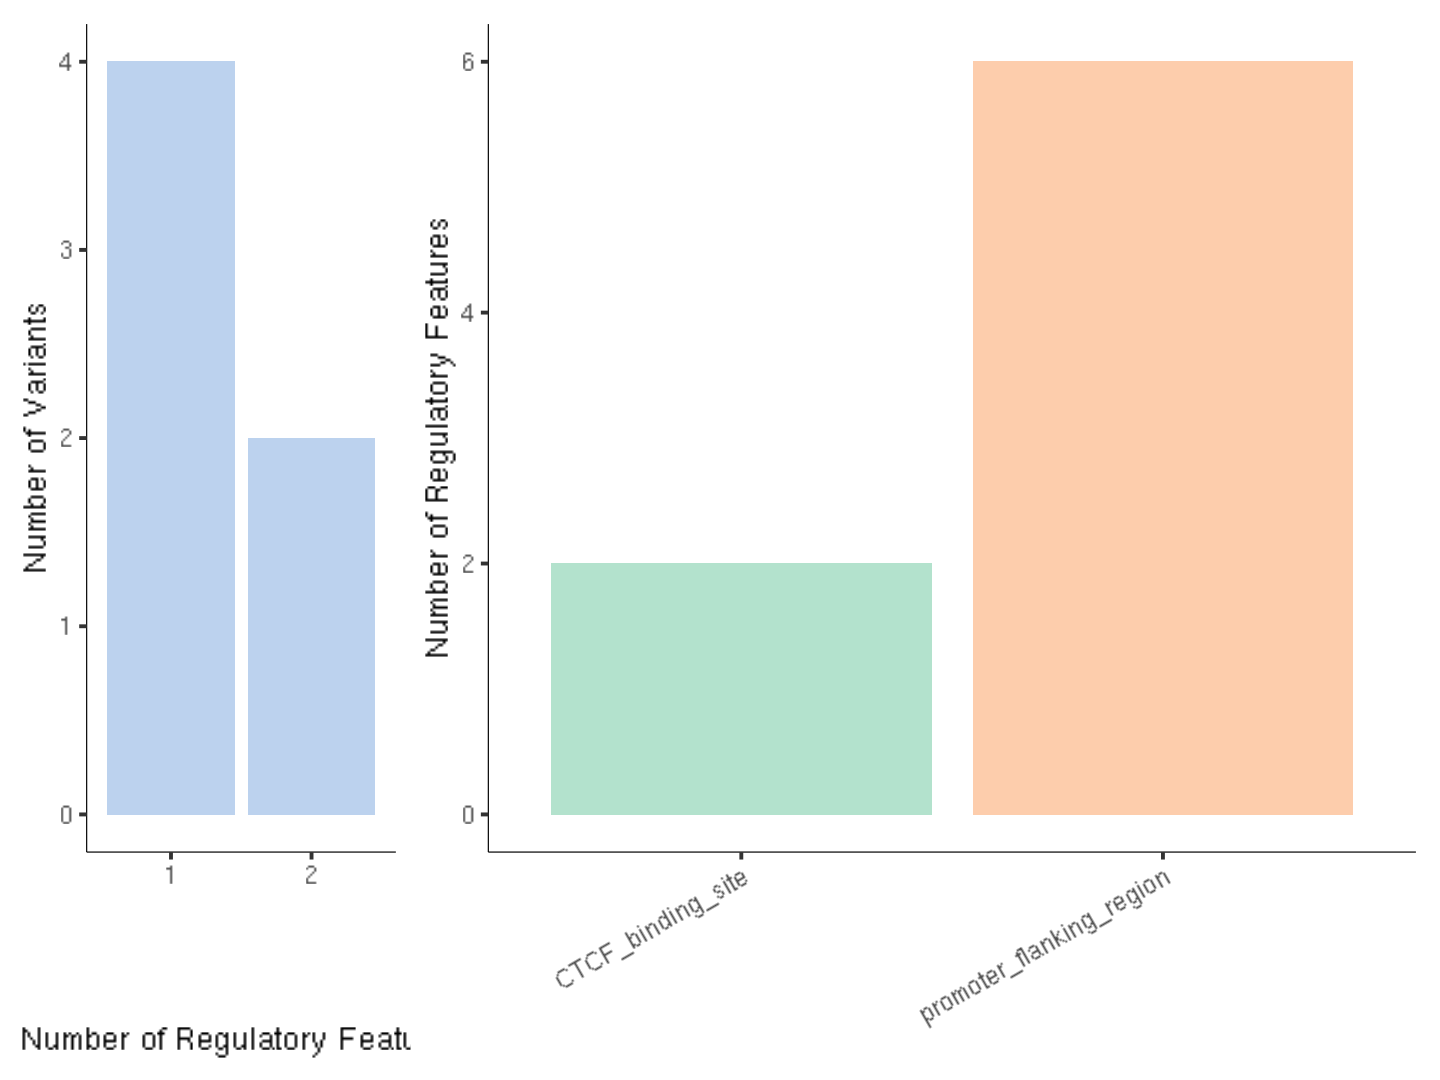

In [43]:
options(repr.plot.width=12, repr.plot.height=9)

p1 <- cis.pqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature) %>%
    unique() %>%
    dplyr::count(ID) %>%
    dplyr::mutate(n=factor(n, levels=1:max(n))) %>%
    ggplot() +
    geom_bar(aes(x=n), fill="lightsteelblue2") +
    xlab("Number of Regulatory Features") + ylab("Number of Variants") +
    ggplot_theme

p2 <- cis.pqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature, BIOTYPE) %>%
    unique() %>%
    ggplot() +
    geom_bar(aes(x=BIOTYPE, fill=BIOTYPE)) +
    guides(fill="none") + ylab("Number of Regulatory Features") +
    scale_fill_brewer(palette="Pastel2") +
    ggplot_theme +
    theme(axis.text.x=element_text(angle=30, hjust=1), axis.title.x=element_blank())

p1 + p2 + patchwork::plot_layout(widths=c(1, 3))

# ggsave("03_Functional_Interpretation/results/ensembl_vep_n_regulatory_features.svg", width=12, height=9)

In [44]:
cis.pqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature) %>%
    unique() %>%
    dplyr::count(ID) %>%
    dplyr::count(n) %>%
    dplyr::mutate(total=sum(nn)) %>%
    dplyr::mutate(prop=nn / total)

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.


n,nn,total,prop
<int>,<int>,<int>,<dbl>
1,4,6,0.6666667
2,2,6,0.3333333


In [45]:
cis.pqtl.vep %>%
    dplyr::filter(Feature_type == "RegulatoryFeature") %>%
    dplyr::select(ID, Feature, BIOTYPE) %>%
    unique() %>%
    dplyr::count(BIOTYPE) %>%
    dplyr::mutate(total=sum(n)) %>%
    dplyr::mutate(prop=n / total)

BIOTYPE,n,total,prop
<chr>,<int>,<int>,<dbl>
CTCF_binding_site,2,8,0.25
promoter_flanking_region,6,8,0.75


Some variants are also in motifs.

In [46]:
cis.pqtl.vep %>%
    dplyr::count(Feature_type)

Feature_type,n
<chr>,<int>
RegulatoryFeature,16
Transcript,476
NA,4


## Trans-pQTL

Tables on these features are provided by [McLaren *et al.*](https://doi.org/10.1186/s13059-016-0974-4).

In [50]:
trans.pqtl.vep <- merge(vep, trans.pqtl, by.x="ID", by.y="SNP") %>%
    dplyr::select(
        ID, Allele, Feature, Consequence,                                    # Index variables
        CHROM, POS, REF, ALT,                                                # Variant information
        pGene=pQTL_Protein,                                                  # pQTL information
        Gene=Gene, Feature_type, BIOTYPE,                                    # Gene and transcript information
        ENSP, UNIPARC, SIFT, PolyPhen,                                       # Protein information
        MOTIF_NAME, TRANSCRIPTION_FACTORS, HIGH_INF_POS, MOTIF_SCORE_CHANGE, # Transcription factor information
        CLIN_SIG                                                             # Literature annotations
    )

4 of the 6 trans-pQTL have a predicted consequence

In [51]:
trans.pqtl.vep %>%
    dplyr::count(ID) %>%
    nrow()

trans.pqtl %>%
    dplyr::count(SNP) %>%
    nrow()

[1] 4

[1] 6

In [59]:
trans.pqtl.vep %>%
    dplyr::filter(Feature_type == "Transcript") %>%
    dplyr::select(CHROM, pGene, ID, Gene, Consequence) %>%
    unique() %>%
    dplyr::arrange(CHROM, Gene)

CHROM,pGene,ID,Gene,Consequence
<int>,<chr>,<chr>,<chr>,<chr>
8,P35858,rs16917722,ENSG00000253773,intron_variant
8,P35858,rs16917722,ENSG00000253773,non_coding_transcript_variant
14,P00751,rs11846959,ENSG00000197249,intron_variant
14,P02787,rs11846959,ENSG00000197249,intron_variant
14,P00751,rs11846959,ENSG00000197249,NMD_transcript_variant
14,P02787,rs11846959,ENSG00000197249,NMD_transcript_variant
14,P00751,rs11846959,ENSG00000197249,downstream_gene_variant
14,P02787,rs11846959,ENSG00000197249,downstream_gene_variant
14,Q92954,rs28929474,ENSG00000197249,missense_variant


In [63]:
trans.pqtl.vep %>%
    dplyr::count(Feature_type)

Feature_type,n
<chr>,<int>
Transcript,172
